# Homework 6

Taking inspiration from the last 2 pictures within the notebook (07-convnets.ipynb), implement a U-Net-style CNN with the following specs:
 
1. All convolutions must use a 3 x 3 kernel and **leave the spatial dimensions (i.e. height, width) of the input untouched**.
2. Downsampling in the contracting part is performed via maxpooling with a 2 x 2 kernel and stride of 2.
3. Upsampling is operated by a deconvolution with a 2 x 2 kernel and stride of 2. The PyTorch module that implements the deconvolution is `nn.ConvTranspose2d`
4. The final layer of the expanding part has only 1 channel
    * between how many classes are we discriminating?
 
Create a network class with (at least) a `__init__` and a `forward` method. Please resort to additional structures (e.g., `nn.Module`s, private methods...) if you believe it helps readability of your code.
 
Test, at least with random data, that the network is doing the correct tensor operations and that the output has the correct shape (e.g., use `assert`s in your code to see if the byproduct is of the expected shape).
 
Note: the overall organization of your work can greatly improve readability and understanding of your code by others. Please consider preparing your notebook in an organized fashion so that we can better understand (and correct) your implementation.

![](../labs/img/unet_small.png)

#### U-Net [3](https://arxiv.org/abs/1505.04597)

The architecture is a composition of two parts: a contracting module and an expanding module.

The contracting module is a sequence of VGG convolutional blocks. 

After reaching the bottom part, we begin upsampling the image following the inverse of the scheme from the contracting module, with an additional operation: we concatenate the output of the upsampling with the output from the last convolutional layer of the corresponding block (as in the image). Thus, if the upsampling yields a 256-channel output, we concatenate this output with the output of the last 256-channel convolutional layer from the contracting module. This leaves us with a 512-channel tensor which we convolve to 256-channels once again. Note that, if the spatial dimensions of the data from the contracting module doesn't match those of the upsampled data, cropping is operated so that we can safely concatenate the two tensors.

Actually, the original implementation of U-Net operates a semantic segmentation on a window which is approximately 2/3 of the original image (there will hence be a leftover band of pixels outside the center of the image). In the image below, the white thin lines represent the area that will be subject to the segmentation.

![](../labs/img/unet_crop.jpg)

For what concerns the output, instead, we end up with a tensor of shape $h^\prime \times w^\prime \times C$, where $C$ denotes the number of the classes we want to operate segmentation (logically speaking, **if we want to classify each pixel, we wish to produce a softmax for each pixel**).

![](../labs/img/unet_last.jpg)

In [1]:
!pip install torch-summary

In [2]:
import torch
from torch import nn
import torchvision.transforms as T
from torchsummary import summary

import numpy as np
import cv2 #opencv
from matplotlib import pyplot as plt

In [3]:
class Contraction(nn.Module):
    
    def _build_vgg_block(self, in_channels, out_channels, kernel_size=3, stride=1, activation=nn.ReLU, maxpool=True):
        layers = []
        if maxpool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
        layers.append(activation())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size, stride))
        layers.append(activation())
        return nn.Sequential(*layers)

    def __init__(self, in_channels=1):
        super().__init__()
        self.block1 = self._build_vgg_block(in_channels=in_channels, out_channels=64, maxpool=False)
        self.block2 = self._build_vgg_block(in_channels=64,  out_channels=128)
        self.block3 = self._build_vgg_block(in_channels=128, out_channels=256)
        self.block4 = self._build_vgg_block(in_channels=256, out_channels=512)
        self.block5 = self._build_vgg_block(in_channels=512, out_channels=1024)

    def forward(self, X):
        copy1 = self.block1(X)
        copy2 = self.block2(copy1)
        copy3 = self.block3(copy2)
        copy4 = self.block4(copy3)
        out   = self.block5(copy4)
        return [copy1, copy2, copy3, copy4, out]

In [4]:
class Expansion(nn.Module):

    def _build_block(self, in_channels, out_channels, kernel_size=3, stride=1, activation=nn.ReLU):
        deconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride),
            activation()
        )
        return seq, deconv

    def __init__(self, in_channels=1024, bias=False):
        super().__init__()
        self.block1, self.deconv1 = self._build_block(in_channels=in_channels, out_channels=512)
        self.block2, self.deconv2 = self._build_block(in_channels=512, out_channels=256)
        self.block3, self.deconv3 = self._build_block(in_channels=256, out_channels=128)
        self.block4, self.deconv4 = self._build_block(in_channels=128, out_channels=64)

    def upsampling(self, out, copy):
        # crop
        cropped_copy = T.CenterCrop(size = out.shape[-1])(copy)
        # concatenate
        out = torch.cat([cropped_copy, out], dim=1)
        return out

    def forward(self, X, copy1, copy2, copy3, copy4):
        out = self.deconv1(X)
        out = self.block1(self.upsampling(out, copy4))
        out = self.deconv2(out)
        out = self.block2(self.upsampling(out, copy3))
        out = self.deconv3(out)
        out = self.block3(self.upsampling(out, copy2))
        out = self.deconv4(out)
        out = self.block4(self.upsampling(out, copy1))
        return out

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.contraction = Contraction(in_channels=in_channels)
        self.expansion = Expansion(in_channels=1024)
        self.final = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)
    
    def forward(self, X):
        # contracting module
        [copy1, copy2, copy3, copy4, out] = self.contraction(X)
        # expanding module
        out = self.expansion(out, copy1, copy2, copy3, copy4)
        # final layer
        out = self.final(out)
        return out

From the image of the UNet we see that we pass from one channel to 64, then to 128, then to 256, to 512 and finally to 1024.

In [6]:
net = UNet(in_channels=1)
_ = summary(net)

Layer (type:depth-idx)                   Param #
├─Contraction: 1-1                       --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  640
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  36,928
|    |    └─ReLU: 3-4                    --
|    └─Sequential: 2-2                   --
|    |    └─MaxPool2d: 3-5               --
|    |    └─Conv2d: 3-6                  73,856
|    |    └─ReLU: 3-7                    --
|    |    └─Conv2d: 3-8                  147,584
|    |    └─ReLU: 3-9                    --
|    └─Sequential: 2-3                   --
|    |    └─MaxPool2d: 3-10              --
|    |    └─Conv2d: 3-11                 295,168
|    |    └─ReLU: 3-12                   --
|    |    └─Conv2d: 3-13                 590,080
|    |    └─ReLU: 3-14                   --
|    └─Sequential: 2-4                   --
|    |    └─MaxPool2d: 3-15              --
|    |    └─Conv2d: 3-16                 1,180,

Test if the net works on random data

In [7]:
def implot(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

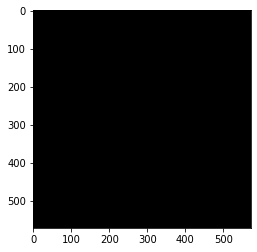

In [8]:
X = np.zeros((572, 572, 1), dtype="uint8")
implot(X)
X = torch.tensor(X)

In [9]:
X = torch.rand((1,1,572,572))

In [10]:
y = net(X)
# print(y)
print(y.shape)

torch.Size([1, 1, 388, 388])


In [11]:
print(net)
# equal to
# UNet()

UNet(
  (contraction): Contraction(
    (block1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
    (block2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
    )
    (block3): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
    )
    (block4): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Conv2d(512, 

In [15]:
z = X
print("in", z.shape)

print("\nContracting module")
contraction_layer = [net.contraction.block1, net.contraction.block2, net.contraction.block3, net.contraction.block4, net.contraction.block5]
copy = []
for i, block in enumerate(contraction_layer):
    for j, mod in enumerate(block):
        z = mod(z)
        if isinstance(mod, nn.Conv2d):
         print(f"block{i+1} {j} {z.shape}")
    copy.append(z)

print("\nExpanding module")
expansion_blocks = [net.expansion.block1, net.expansion.block2, net.expansion.block3, net.expansion.block4]
expansion_deconvs = [net.expansion.deconv1, net.expansion.deconv2, net.expansion.deconv3, net.expansion.deconv4]

for i in range(4):
    z = expansion_deconvs[i](z)
    print(f"deconv{i+1} {z.shape}")
    z = net.expansion.upsampling(z, copy[4-i-1])
    for j, mod in enumerate(expansion_blocks[i]):
        z = mod(z)
        if isinstance(mod, nn.Conv2d):
          print(f"block{i+1} {j} {z.shape}")

z = net.final(z)
print("final", z.shape)

in torch.Size([1, 1, 572, 572])

Contracting module
block1 0 torch.Size([1, 64, 570, 570])
block1 2 torch.Size([1, 64, 568, 568])
block2 1 torch.Size([1, 128, 282, 282])
block2 3 torch.Size([1, 128, 280, 280])
block3 1 torch.Size([1, 256, 138, 138])
block3 3 torch.Size([1, 256, 136, 136])
block4 1 torch.Size([1, 512, 66, 66])
block4 3 torch.Size([1, 512, 64, 64])
block5 1 torch.Size([1, 1024, 30, 30])
block5 3 torch.Size([1, 1024, 28, 28])

Expanding module
deconv1 torch.Size([1, 512, 56, 56])
block1 0 torch.Size([1, 512, 54, 54])
block1 2 torch.Size([1, 512, 52, 52])
deconv2 torch.Size([1, 256, 104, 104])
block2 0 torch.Size([1, 256, 102, 102])
block2 2 torch.Size([1, 256, 100, 100])
deconv3 torch.Size([1, 128, 200, 200])
block3 0 torch.Size([1, 128, 198, 198])
block3 2 torch.Size([1, 128, 196, 196])
deconv4 torch.Size([1, 64, 392, 392])
block4 0 torch.Size([1, 64, 390, 390])
block4 2 torch.Size([1, 64, 388, 388])
final torch.Size([1, 1, 388, 388])


### References

[1](https://arxiv.org/abs/1603.07285) Dumoulin, Vincent, and Francesco Visin. "A guide to convolution arithmetic for deep learning."

[2](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition

[3](https://arxiv.org/abs/1505.04597) Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention.

[4](https://arxiv.org/abs/1605.07146) Zagoruyko, Sergey, and Nikos Komodakis. "Wide residual networks."

[5](https://arxiv.org/abs/1409.1556v6) Simonyan and Zisserman. "Very Deep Convolutional Networks for Large-Scale Image Recognition."